# Introduction
- To predict and localize brain tumors through image segmentation
- First I have Collect data then I made a Dataframe. Then I do some visualization. After doing this, I Build Resnet50 Model for predicting whether data has mask or not.
- To locate the mask in image (Brain Tumor Localization), I built my own ResBlock and UNet Model.
- *Go through this code file, if you found helpful please do upvote. **Suggestions are always welcome.** Don't hesitate to do comments if you want to suggest or ask anything.*
**Thank You**

- X will be a NumPy array of shape [batch_size, input_height, input_width, input_channel].

# Import required libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

import cv2
from skimage import io
import tensorflow as tf
from IPython.display import display
import os
import glob
import random
%matplotlib inline

In [2]:
# data containing path to Brain MRI and their corresponsing mask
brain_df = pd.read_csv('../input/lgg-mri-segmentation/kaggle_3m/data.csv')

# Exploratory Data Analysis

In [3]:
brain_df.head()

Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                1.0         3.0             2.0   
1                        2.0                1.0         3.0             2.0   
2                        2.0                1.0         1.0             2.0   
3                        1.0                1.0         3.0             6.0   
4                        2.0                1.0         1.0             6.0   

   gender  age_at_initial_pathologic  race  ethnicity  death01  
0     2.0                       67.0   3.0        2.0      1.0  
1     1.0                       44.0   2.0        NaN      1.0  
2     2.0                       37.0   3.0        NaN      0.0  
3     2.0                       50.0   3.0        NaN      0.0  
4     2.0                       39.0   3.0        NaN      0.0

In [4]:
brain_df.shape

(110, 18)

In [5]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

## Making list of folders name and images name
- We are making here a list of all images name with the name of the folder in which the image in.

In [6]:
data_map = []   # It will contain all folders name followed by one image name inside that folder, like this "folder1","image1","folder1","image2"
for sub_dir_path in glob.glob("../input/lgg-mri-segmentation/kaggle_3m//" + "*"):
    try:
        dir_name = sub_dir_path.split('/')[-1]  # Folders name 
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename  # Name of all individual images present in a folder
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: '../input/lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: '../input/lgg-mri-segmentation/kaggle_3m/data.csv'


In [7]:
data_map[0:6]

['TCGA_DU_7010_19860307',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif',
 'TCGA_DU_7010_19860307',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif',
 'TCGA_DU_7010_19860307',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif']

In [8]:
data_map[::2][0:3]

['TCGA_DU_7010_19860307', 'TCGA_DU_7010_19860307', 'TCGA_DU_7010_19860307']

In [9]:
data_map[1::2][0:3]

['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif',
 '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_57.tif']

## Dataframe
- We are creating dataframe in which patient id (folder name) will be one column and path (path of images stored) is another column

In [10]:
df = pd.DataFrame({"patient_id" : [i[:] for i in data_map[::2]], 
                  "path" : data_map[1::2]})
df.head()

patient_id                                               path
0  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...

In [11]:
data_map[1]

'../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif'

**Length of one path (path of image)**

In [12]:
data_map[1::2][0]

'../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif'

In [13]:
BASE_LEN = len("../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_")
BASE_LEN

84

### Seperate mask image and non mask image and making dataframe of each seperately

In [14]:
df.head()

patient_id                                               path
0  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
1  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...

In [15]:
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

print(df_imgs["path"][0])
print(df_masks.path[1])

display(df_imgs.head())
display(df_masks.head())

../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_45.tif
../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56_mask.tif


patient_id                                               path
0  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
2  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
3  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
4  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
5  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...

patient_id                                               path
1   TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
7   TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
8   TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
9   TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...
11  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...

In [16]:
df_masks["path"][1][84:-9]

'56'

### Sorting data of images and masks

In [17]:
BASE_LEN = BASE_LEN         # BASE_LEN = 100
END_IMG_LEN = 4
END_MASK_LEN = 9

# Data Sorting
imgs = sorted(df_imgs["path"].values, key = lambda x : (x[BASE_LEN:-END_IMG_LEN]))
masks = sorted(df_masks["path"].values, key = lambda x : (x[BASE_LEN:-END_MASK_LEN]))

# Sorting Check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: ../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_17.tif 
Path to the Mask: ../input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_6186_20000601/TCGA_CS_6186_20000601_17_mask.tif


In [18]:
# Sorting Check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

Path to the Image: ../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_5.tif 
Path to the Mask: ../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7302_19911203/TCGA_DU_7302_19911203_5_mask.tif


### Creating New Dataframe containing image path and mask path combinely as seperate column

In [19]:
brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                        "image_path": imgs,
                        "mask_path" : masks
                        })
brain_df.head()

patient_id                                         image_path  \
0  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
3  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
4  TCGA_DU_7010_19860307  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                           mask_path  
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...  
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...  
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...  
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...

In [20]:
brain_df.image_path[0]

'../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif'

### Creating Mask column
- 1 indicates np.max is 0 and hence it is masked
- 0 indicates np.max is greater than 0 and hence it is not masked (black color)

In [21]:
print(brain_df["image_path"][0])
print(brain_df["mask_path"][0])

../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1.tif
../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_1_mask.tif


In [22]:
def pos_neg_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 :
        return 1
    else:
        return 0

brain_df['mask'] = brain_df['mask_path'].apply(lambda x : pos_neg_diagnosis(x))
brain_df

patient_id  \
0     TCGA_DU_7010_19860307   
1     TCGA_DU_7010_19860307   
2     TCGA_DU_7010_19860307   
3     TCGA_DU_7010_19860307   
4     TCGA_DU_7010_19860307   
...                     ...   
3924  TCGA_DU_7306_19930512   
3925  TCGA_DU_7306_19930512   
3926  TCGA_DU_7306_19930512   
3927  TCGA_DU_7306_19930512   
3928  TCGA_DU_7306_19930512   

                                             image_path  \
0     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
1     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
3     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
4     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
...                                                 ...   
3924  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3925  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
3926  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
3927  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
3928  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                              mask_path  mask  
0     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
1     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
2     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...     0  
3     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...     0  
4     ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
...                                                 ...   ...  
3924  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...     0  
3925  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...     0  
3926  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...     0  
3927  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  
3928  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0  

[3929 rows x 4 columns]

In [23]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

In [24]:
brain_df[brain_df["image_path"]=="../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_23.tif"]

patient_id  \
1617  TCGA_DU_6401_19831001   

                                             image_path  \
1617  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                              mask_path  mask  
1617  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     0

In [25]:
brain_df[brain_df["image_path"]=="../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_24.tif"]

patient_id  \
1702  TCGA_HT_7473_19970826   

                                             image_path  \
1702  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                              mask_path  mask  
1702  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1

# Data Visualization

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='mask', ylabel='count'>

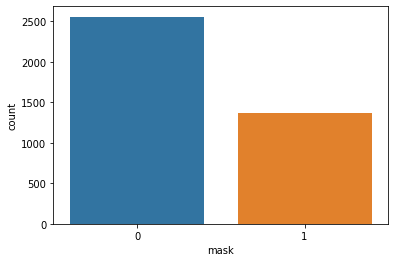

In [26]:
sns.countplot(brain_df['mask'])

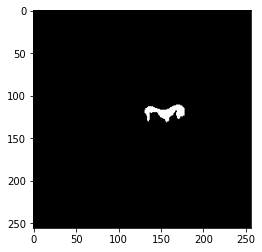

In [27]:
plt.imshow(cv2.imread(brain_df.mask_path[1702]))

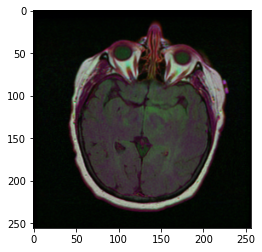

In [28]:
plt.imshow(cv2.imread(brain_df.image_path[1702]))

In [29]:
brain_df.image_path[1702]

'../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_24.tif'

In [30]:
brain_df.mask_path[1702]

'../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_24_mask.tif'

## Image and its Mask image visualization

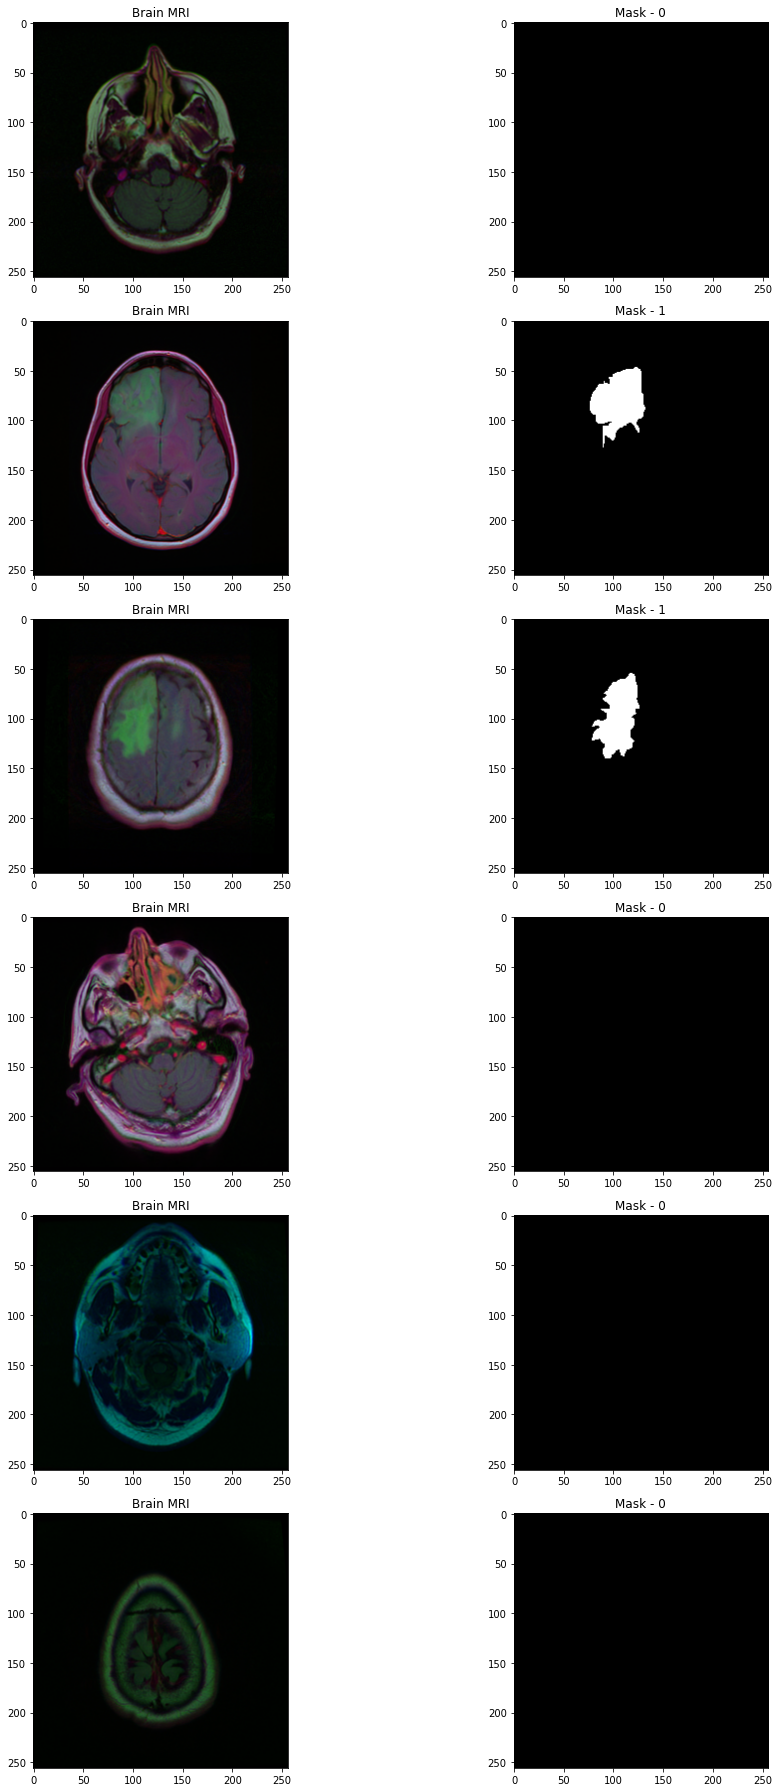

In [31]:
fig, axs = plt.subplots(6, 2, figsize = (16,25))
count = 0
for x in range(6):
    i = random.randint(0, len(brain_df))   # select a random index
    axs[count][0].title.set_text("Brain MRI")  # Set Title
    axs[count][0].imshow(cv2.imread(brain_df.image_path[i]))  # show MRI
    axs[count][1].title.set_text("Mask - " + str(brain_df['mask'][i]))
    axs[count][1].imshow(cv2.imread(brain_df.mask_path[i]))
    count += 1
fig.tight_layout()

## MRI with MASK

In [32]:
len(brain_df)

3929

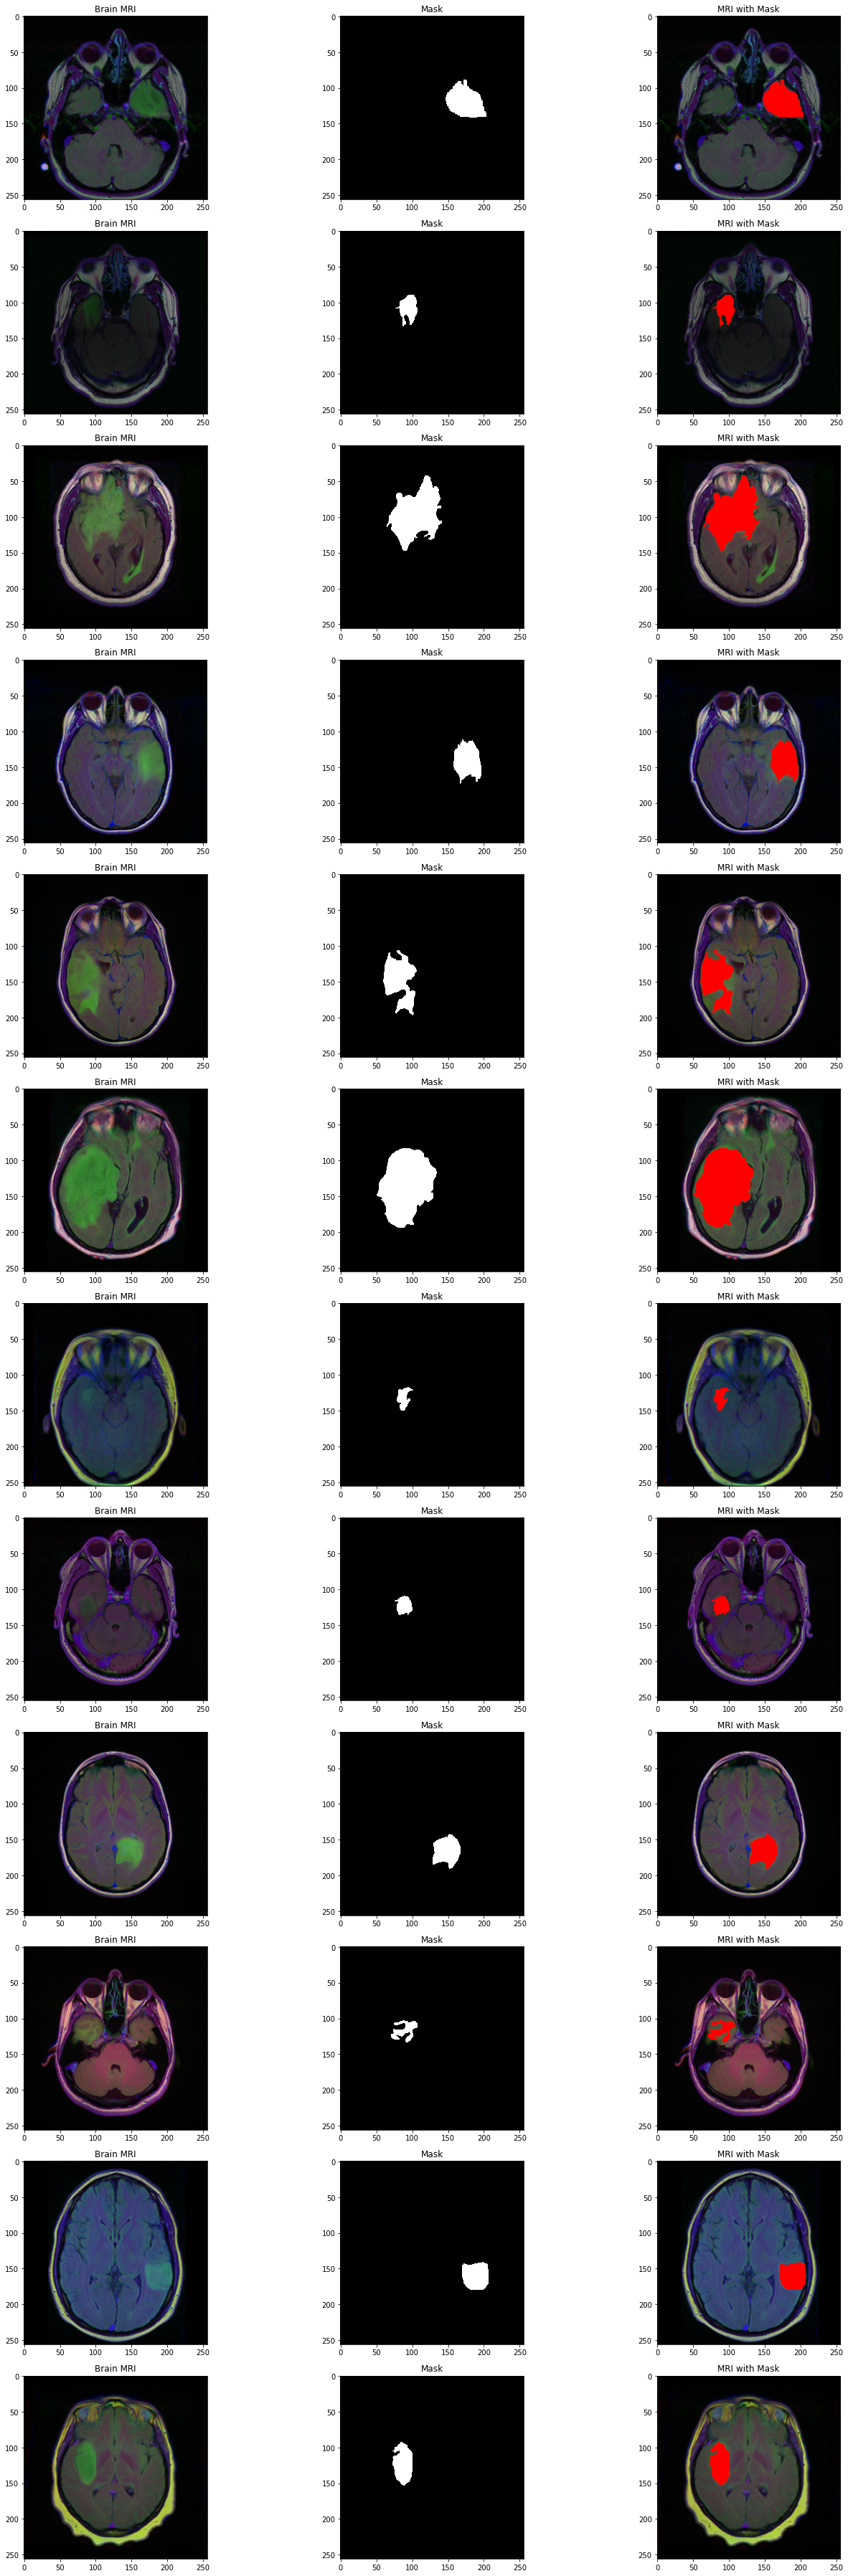

In [33]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20,50))
for i in range(len(brain_df)):
    if brain_df['mask'][i] == 1 and count < 12:
        img = io.imread(brain_df.image_path[i])    # Defining path of image data which are mask = 1
        axs[count][0].title.set_text("Brain MRI")  # Set Title
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])  # Defining path of mask data which are mask = 1
        axs[count][1].title.set_text("Mask")  # Set Title
        axs[count][1].imshow(mask, cmap = 'gray')
        
        img[mask == 255] = (255, 0, 0)
        axs[count][2].title.set_text("MRI with Mask")
        axs[count][2].imshow(img)
        count+=1
fig.tight_layout()

# Making Training data from Brain dataframe

In [34]:
# Drop the patient id column
brain_df_train = brain_df.drop('patient_id', axis = 1)
brain_df_train.shape

(3929, 3)

In [35]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x : str(x))

In [36]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


# Split Data into Train & Test

In [37]:
# Split the data into train and test data
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size = 0.15)

In [38]:
train.head()

image_path  \
498   ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
2076  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
2890  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
1622  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
179   ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   

                                              mask_path mask  
498   ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...    1  
2076  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    0  
2890  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...    0  
1622  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1  
179   ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...    1

# Image Augmentation

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

- Augment more data using ImageDataGenerator. ImageDataGenerator generates batches of tensor image data with real-time data augmentation.

In [39]:
# Create an Image Generator
from keras_preprocessing.image import ImageDataGenerator

# Create a data generator which scales the data from 0 to 1 and makes validation split for 15%
datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.15)

In [40]:
train_generator = datagen.flow_from_dataframe(dataframe=train, directory = None, x_col = 'image_path', y_col = 'mask',
                                             subset = 'training', batch_size=16, shuffle=True, class_mode='categorical',
                                             target_size = (256,256))

valid_generator = datagen.flow_from_dataframe(dataframe=train, directory = None, x_col = 'image_path', y_col = 'mask',
                                             subset = 'validation', batch_size=16, shuffle=True, class_mode='categorical',
                                             target_size = (256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.


In [41]:
# Create a data generator which scales the data from 0 to 1
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(dataframe = test, directory = None, x_col='image_path', y_col='mask',
                                              batch_size=16, shuffle=False, class_mode='categorical',
                                              target_size = (256,256))

Found 590 validated image filenames belonging to 2 classes.


# Transfer Learning Model - ResNet50 Model

- Transfer Learning as the name suggests, is a technique to use the pre-trained models in your training. You can build your model on top of this pre-trained model. This is a process that helps you decrease the development time and increase performance.

- ResNet (Residual Network) is the ANN trained on the ImageNet dataset that can be used to train the model on top of it. ResNet50 is the variant of the ResNet model which has 48 Convolution layers along with 1 MaxPool and 1 Average Pool layer.

In [42]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras import Input
from tensorflow.keras import layers

In [43]:
# Get the ResNet50 base Model, weights = imagenet
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))
# include_top: whether u want to add last layer of resnet

2022-06-11 06:32:34.224794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 06:32:34.331219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 06:32:34.332141: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-11 06:32:34.333459: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 0s 0us/step


In [44]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [45]:
# Build Transfer Learning 
def build_model():
    # Use Imagenet = pre-trained models weights called as knowledge transfer
    # Image shape = 32x32x3
    basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256,256,3)))
    
    # Input Layer
    model = Sequential()
    # Padding = 'same'
    model.add(Conv2D(filters = 3, kernel_size = (3,3), padding = 'same', input_shape = (256,256,3)))
    # padding=same means size of i/p = size of o/p
    
    # add transfer learning
    model.add(basemodel)
    
    # average pooling layer
    model.add(AveragePooling2D())
    model.add(Flatten())
    # To avoid overfitting
    model.add(BatchNormalization())
    
    # Fully Connected Layer
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dropout(0.3))
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dropout(0.3))
    # Output Layer
    model.add(Dense(units = 2, activation = 'softmax'))
    
    # Model Compile
    model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [46]:
model = build_model()

In [ ]:
# save best model 
from tensorflow.keras import callbacks
filepath = "./MRIResnet.hdf5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', save_best_model=True, mode='min', verbose=1)
checkpoint

In [ ]:
# early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode = 'min', verbose=1, patience = 20)

In [ ]:
history = model.fit(train_generator, steps_per_epoch = train_generator.n // 16, epochs=30, validation_data= valid_generator,
                   validation_steps=valid_generator.n // 16, callbacks=[checkpoint,earlystopping])

In [47]:
model.load_weights("../input/mriresnet/MRIResnet.hdf5")

In [48]:
model.evaluate(test_generator)

2022-06-11 06:34:22.563201: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-11 06:34:24.956620: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


37/37 [==============================] - 13s 134ms/step - loss: 0.0876 - accuracy: 0.9610


[0.08759422600269318, 0.9610169529914856]

In [49]:
y_pred = model.predict(test_generator)

In [50]:
yhat = np.argmax(y_pred, axis = 1)
ytest = np.asarray(test['mask']).astype('int')   # test = It came from train_test_split

In [51]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(ytest, yhat)

array([[366,  15],
       [  8, 201]])

## Confusion Matrix - ResNet50

<AxesSubplot:>

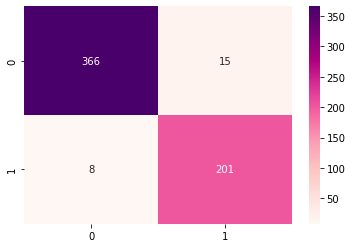

In [52]:
sns.heatmap(confusion_matrix(ytest, yhat), annot = True, cmap = 'RdPu', fmt = '0.0f')

In [53]:
print(classification_report(ytest, yhat))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       381
           1       0.93      0.96      0.95       209

    accuracy                           0.96       590
   macro avg       0.95      0.96      0.96       590
weighted avg       0.96      0.96      0.96       590



# Build Image Segmentation Model to Localize Tumor

## Seperating data with mask

In [54]:
# Get the dataframe containing MRI which have masks associated with them.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [56]:
brain_df_mask.head()

patient_id                                         image_path  \
112  TCGA_FG_A4MT_20020212  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
114  TCGA_FG_A4MT_20020212  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
122  TCGA_FG_A4MT_20020212  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
128  TCGA_FG_A4MT_20020212  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
134  TCGA_FG_A4MT_20020212  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   

                                             mask_path  mask  
112  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...     1  
114  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...     1  
122  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...     1  
128  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...     1  
134  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...     1

## Creating train, test, and validation

In [60]:
# Creating test, train and val sets 
x_train, x_val = train_test_split(brain_df_mask, test_size = 0.15)
x_test, x_val = train_test_split(x_val, test_size=0.15)
print("Train size is {} , Validation size is {} & test size is {}".format(len(x_train), len(x_val), len(x_test)))

Train size is 1167 , Validation size is 31 & test size is 175


In [61]:
train_ids = list(x_train.image_path)
train_mask = list(x_train.mask_path)

In [62]:
val_ids = list(x_val.image_path)
val_mask = list(x_val.mask_path)

# Custom Data Generator 
- Generate your dataset on multiple cores in real time and feed it right away to your deep learning model. Simply to do task efficiently

- Why do I need a custom Data Generator?
    - The Standard Keras Generator has limited functionalities. For example, if your network has multiple output nodes, you won't be able to use the standard data generator. It also does not support tabular data. So if you have a large tabular dataset, you will need to write a custom generator. Above all, it is very easy to implement a data generator for Keras and it is extremely powerful and flexible. We can implement complex functions and preprocessing on the data before it is given as input to the model.

In [63]:
from skimage import io
from PIL import Image
import os
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras import Model

https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

https://medium.com/analytics-vidhya/write-your-own-custom-data-generator-for-tensorflow-keras-1252b64e41c3

- The role of '__ getitem __ ' method is to generate one batch of data. In this case, one batch of data will be (X, y) value pair where X represents the input and y represents the output.

In [65]:
# Create UDF (User Defined Function) for data generator
class DataGenerator(Sequence):
    def __init__(self, ids, mask, image_dir=' ', batch_size=16, img_h=256, img_w=256, shuffle=True):
        self.ids = ids
        self.mask = mask
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.img_h = img_h
        self.img_w = img_w
        self.shuffle = shuffle
        self.on_epoch_end()
        
        
    def __len__(self):
        '''
        Get the number of batches per epoch
        '''
        return int(np.floor(len(self.ids)) / self.batch_size)
    
    
    def __getitem__(self, index):
        '''
        Generate a batch of data
        '''
        # Generate index of batch_size length
        indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]
        # Get the ImageId corresponding to indexes created above based on batch size
        list_ids = [self.ids[i] for i in indexes]
        # Get the MaskId corresponding to indexes created above based on batch size
        list_mask = [self.mask[i] for i in indexes]
        
        # Generate data for features and label
        x, y = self.__data_generation(list_ids, list_mask)
        return x, y
    
    
    def on_epoch_end(self):
        '''
        Generate indexes and do shuffling
        '''
        # Getting the array of indices based on the input dataframe
        self.indexes = np.arange(len(self.ids))

        # If shuffle is true, shuffle the indices
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    
    def __data_generation(self, list_ids, list_mask):
        '''
        Converting Batch of data to array and standardizing it (by applying same formula as of StandardScaler)
        '''
        # Create empty arrays of shape (batch_size,height,width,depth) 
        # Depth is 3 for input and depth is taken as 1 for output becasue mask consist only of 1 channel.
        x = np.empty((self.batch_size, self.img_h, self.img_w, 3))
        y = np.empty((self.batch_size, self.img_h, self.img_w, 1))
        
        #iterate through the dataframe rows, whose size is equal to the batch_size
        for i in range(len(list_ids)):
            #path of the image
            img_path = str(list_ids[i])
            #mask path
            mask_path = str(list_mask[i])
            #reading the original image and the corresponding mask image
            img = io.imread(img_path)
            mask = io.imread(mask_path)
            
            #resizing and coverting them to array of type float64
            img = cv2.resize(img,(self.img_h,self.img_w))
            img = np.array(img, dtype = np.float64)
            
            mask = cv2.resize(mask,(self.img_h,self.img_w))
            mask = np.array(mask, dtype = np.float64)
            
            #standardising - (by applying same formula as of StandardScaler)
            img -= img.mean()
            img /= img.std()
            
            mask -= mask.mean()
            mask /= mask.std()
            
            #Adding image to the empty array
            x[i,] = img
            #expanding the dimnesion of the image from (256,256) to (256,256,1)
            y[i,] = np.expand_dims(mask, axis = 2)
        #normalizing y
        y = (y > 0).astype(int)
        return x, y

In [66]:
train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

# Resblock

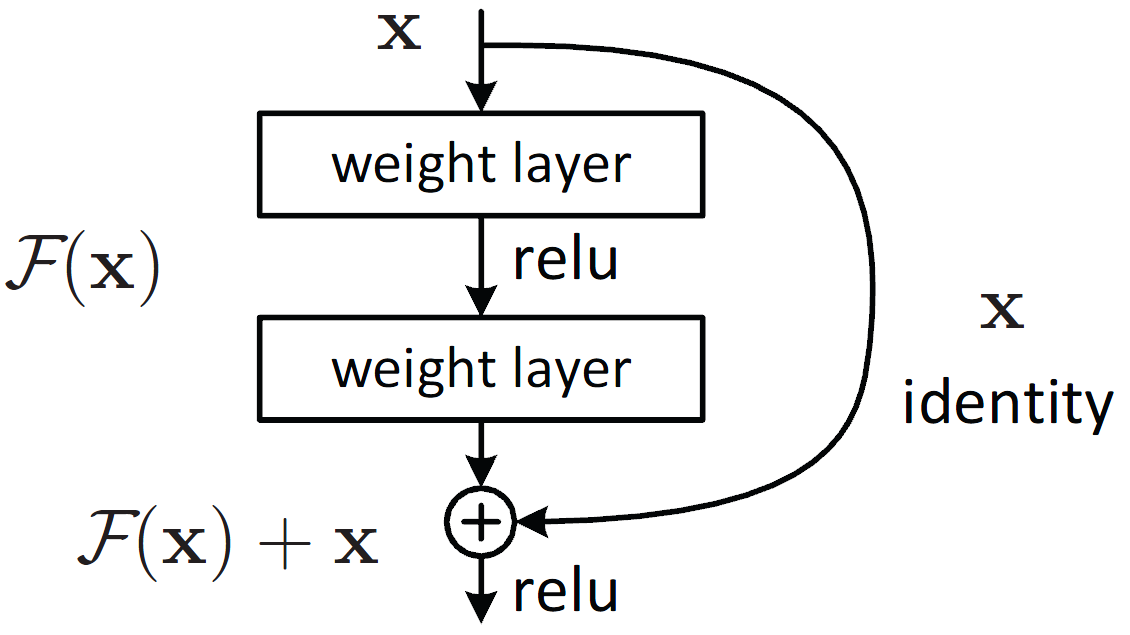

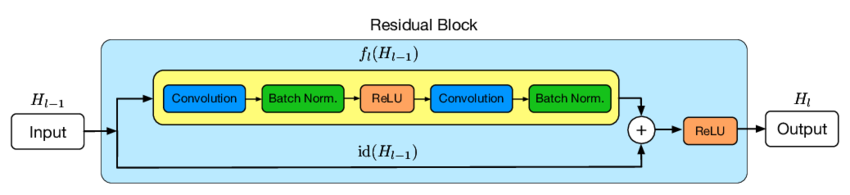

In [67]:
# Two arguments pool, function
def resblock(x, f):
    x_copy = x
    x = Conv2D(f, kernel_size = (1,1), strides = (1,1), kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(f, kernel_size=(3,3), strides=(1,1), padding = 'same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    
    x_copy = Conv2D(f, kernel_size=(1,1), strides=(1,1), kernel_initializer='he_normal')(x_copy)
    x_copy = BatchNormalization()(x_copy)
    
    # Adding the output from main path and short path together
    x = Add()([x, x_copy])
    x = Activation('relu')(x)
    return x

In [68]:
from tensorflow.keras.layers import UpSampling2D

# function to upscale and concatenate the values passed
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])
    return merge

# Res-UNet Model
- https://analyticsindiamag.com/my-experiment-with-unet-building-an-image-segmentation-model/
- https://medium.com/@nishanksingla/unet-with-resblock-for-semantic-segmentation-dd1766b4ff66

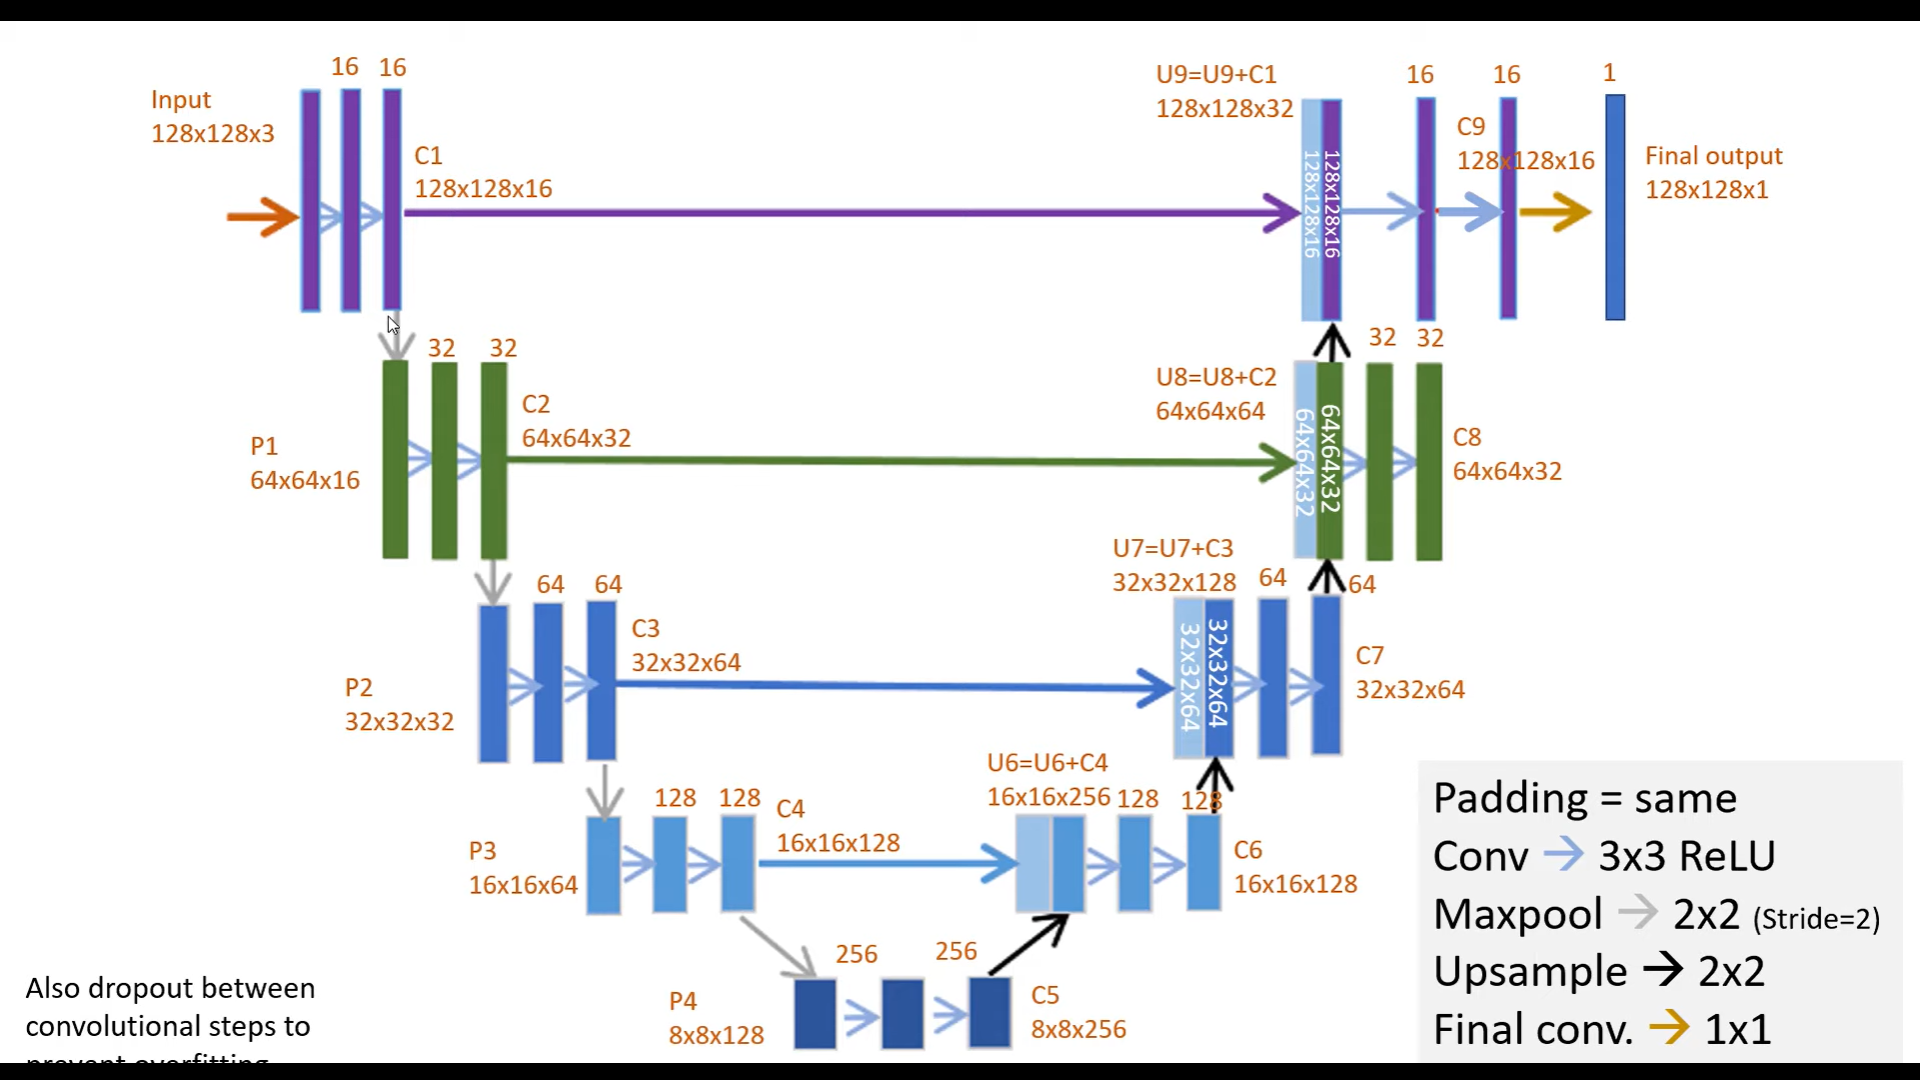

In [87]:
from tensorflow.keras.layers import *
input_shape = (256,256,3)

# Input tensor shape
#https://www.tensorflow.org/api_docs/python/tf/keras/Input
x_input = Input(input_shape)

# Encoder
# Stage 1
conv1_in = Conv2D(16,3,activation = 'relu', padding='same', kernel_initializer='he_normal')(x_input)  #padding=same means i/p dimension = o/p dimension
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation = 'relu', padding='same', kernel_initializer='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Stage 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size=(2,2))(conv2_in)

# Stage 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size=(2,2))(conv3_in)

# Stage 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size=(2,2))(conv4_in)

# Stage 5 (Bottle Neck)
conv5_in = resblock(pool_4, 256)

# Decoder
# Upscale stage 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Upscale stage 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Upscale stage 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Upscale stage 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Final Output
output = Conv2D(1, (1,1), padding='same', activation="sigmoid")(up_4)

#https://www.tensorflow.org/api_docs/python/tf/keras/Model
model_seg = Model(inputs = x_input, outputs = output)

In [88]:
model_seg.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 256, 256, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_53 (BatchNo (None, 256, 256, 16) 64          conv2d_55[0][0]                  
__________________________________________________________________________________________________
conv2d_56 (Conv2D)              (None, 256, 256, 16) 2320        batch_normalization_53[0][0]     
____________________________________________________________________________________________

# Tversky Loss
- It was designed to optimise segmentation on imbalanced medical datasets by utilising constants that can adjust how harshly different types of error are penalised in the loss function.
- To summarise, this loss function is weighted by the constants 'alpha' and 'beta' that penalise false positives and false negatives respectively to a higher degree in the loss function as their value is increased. The beta constant in particular has applications in situations where models can obtain misleadingly positive performance via highly conservative prediction. You may want to experiment with different values to find the optimum.

https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook

In [89]:
# Define a custom loss function for ResUNet model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

epsilon = 1e-5
smooth = 1
# TI - Travesky Index is asymmetric similarity measure that is a generalisation of loss function 
def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

#  focal_travesky = (1-TI)pow gamma
def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [90]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# compling model and callbacks functions
adam = tf.keras.optimizers.Adam(learning_rate = 0.001, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

#callbacks
earlystopping = EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="./SegModel_Weights.hdf5", verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min',verbose=1,patience=10,min_delta=0.0001,factor=0.2)

In [73]:
history = model_seg.fit(train_data, epochs = 60, 
                      validation_data = val_data,
                      callbacks = [checkpointer, earlystopping, reduce_lr])

Epoch 1/60
72/72 [==============================] - 17s 179ms/step - loss: 0.9245 - tversky: 0.0993 - val_loss: 0.9336 - val_tversky: 0.0876

Epoch 00001: val_loss improved from inf to 0.93357, saving model to ./SegModel_Weights.hdf5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/60
72/72 [==============================] - 8s 111ms/step - loss: 0.9098 - tversky: 0.1184 - val_loss: 0.8996 - val_tversky: 0.1316

Epoch 00002: val_loss improved from 0.93357 to 0.89956, saving model to ./SegModel_Weights.hdf5
Epoch 3/60
72/72 [==============================] - 8s 105ms/step - loss: 0.8933 - tversky: 0.1396 - val_loss: 0.8985 - val_tversky: 0.1330

Epoch 00003: val_loss improved from 0.89956 to 0.89848, saving model to ./SegModel_Weights.hdf5
Epoch 4/60
72/72 [==============================] - 8s 109ms/step - loss: 0.8777 - tversky: 0.1595 - val_loss: 0.8787 - val_tversky: 0.1584

Epoch 00004: val_loss improved from 0.89848 to 0.87871, saving model to ./SegModel_Weights.hdf5
Epoch 5/60
72/72 [==============================] - 8s 115ms/step - loss: 0.8646 - tversky: 0.1762 - val_loss: 0.8613 - val_tversky: 0.1805

Epoch 00005: val_loss improved from 0.87871 to 0.86135, saving model to ./SegModel_Weights.hdf5
Epoch 6/60
72/72 [==============================] - 

In [74]:
pd.DataFrame(history.history)

loss   tversky  val_loss  val_tversky       lr
0   0.924526  0.099294  0.933568     0.087580  0.00100
1   0.909773  0.118374  0.899559     0.131627  0.00100
2   0.893281  0.139612  0.898481     0.133015  0.00100
3   0.877714  0.159532  0.878715     0.158352  0.00100
4   0.864588  0.176192  0.861346     0.180460  0.00100
5   0.852422  0.191543  0.835806     0.212699  0.00100
6   0.840446  0.206700  0.828117     0.222341  0.00100
7   0.827270  0.223164  0.820311     0.232099  0.00100
8   0.811772  0.242495  0.794794     0.263782  0.00100
9   0.791619  0.267359  0.771193     0.292786  0.00100
10  0.766870  0.297644  0.728515     0.344482  0.00100
11  0.731736  0.339947  0.716066     0.359374  0.00100
12  0.692678  0.386334  0.614054     0.478074  0.00100
13  0.643826  0.443327  0.511748     0.590669  0.00100
14  0.599373  0.493324  0.564733     0.533207  0.00100
15  0.562892  0.533686  0.562939     0.535183  0.00100
16  0.532908  0.566150  0.592199     0.502694  0.00100
17  0.508904  0.592176  0.512816     0.589529  0.00100
18  0.492562  0.608625  0.399300     0.705965  0.00100
19  0.474320  0.628154  0.569886     0.527519  0.00100
20  0.456143  0.646541  0.473257     0.631196  0.00100
21  0.441859  0.661479  0.422425     0.683043  0.00100
22  0.427789  0.675863  0.413431     0.692009  0.00100
23  0.414734  0.688697  0.398527     0.706724  0.00100
24  0.401146  0.702238  0.491732     0.611876  0.00100
25  0.387241  0.716178  0.405049     0.700307  0.00100
26  0.376334  0.726836  0.263413     0.831144  0.00100
27  0.368111  0.734671  0.279783     0.817009  0.00100
28  0.356457  0.745672  0.258473     0.835353  0.00100
29  0.344470  0.756710  0.305941     0.793850  0.00100
30  0.337897  0.763704  0.351303     0.752120  0.00100
31  0.332310  0.768500  0.277340     0.819137  0.00100
32  0.328992  0.771529  0.299554     0.799568  0.00100
33  0.322117  0.777724  0.269348     0.826053  0.00100
34  0.313670  0.785175  0.297732     0.801192  0.00100
35  0.311460  0.787228  0.269097     0.826268  0.00100
36  0.302813  0.795257  0.351342     0.752083  0.00100
37  0.299741  0.798029  0.263068     0.831439  0.00100
38  0.293001  0.803794  0.273945     0.822083  0.00100
39  0.290299  0.806347  0.304747     0.794922  0.00020
40  0.285434  0.810683  0.233356     0.856333  0.00020
41  0.285694  0.810663  0.231803     0.857606  0.00020
42  0.283475  0.812285  0.273041     0.822865  0.00020
43  0.283523  0.812610  0.247878     0.844290  0.00020
44  0.281665  0.813868  0.240115     0.850758  0.00020
45  0.283506  0.812803  0.242978     0.848380  0.00020
46  0.285337  0.810546  0.284896     0.812537  0.00020
47  0.278142  0.816867  0.291007     0.807156  0.00020
48  0.276704  0.818399  0.249889     0.842603  0.00020
49  0.275647  0.819540  0.244154     0.847401  0.00020
50  0.279816  0.815190  0.253803     0.839307  0.00020
51  0.278574  0.816683  0.239794     0.851024  0.00020
52  0.278280  0.816788  0.223134     0.864662  0.00004
53  0.276109  0.818572  0.285213     0.812259  0.00004
54  0.274468  0.820176  0.236382     0.853843  0.00004
55  0.273913  0.820637  0.281871     0.815187  0.00004
56  0.272712  0.821743  0.237403     0.853001  0.00004
57  0.278116  0.816972  0.218934     0.868047  0.00004
58  0.276178  0.818202  0.280814     0.816110  0.00004
59  0.274392  0.820199  0.259630     0.834370  0.00004

<AxesSubplot:title={'center':'SEG Model Travesky Score'}>

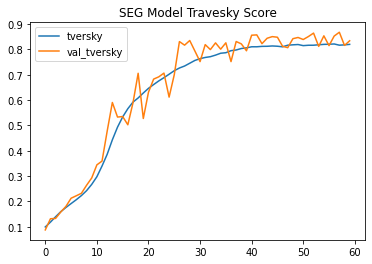

In [75]:
pd.DataFrame(history.history)[['tversky','val_tversky']].plot(title = "SEG Model Travesky Score")

<AxesSubplot:title={'center':'SEG Model Focal Travesky Loss'}>

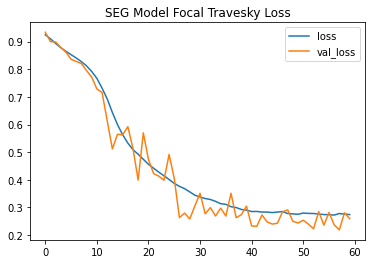

In [76]:
pd.DataFrame(history.history)[['loss','val_loss']].plot(title = "SEG Model Focal Travesky Loss")

In [91]:
model_seg.load_weights("./SegModel_Weights.hdf5")

In [92]:
test_ids = list(x_test.image_path)
test_mask = list(x_test.mask_path)

In [93]:
test_data = DataGenerator(test_ids, test_mask)

In [94]:
model_seg.evaluate(test_data)

10/10 [==============================] - 2s 106ms/step - loss: 0.2681 - tversky: 0.8263


[0.26808223128318787, 0.8263155817985535]

# Making Prediction on each data and creating dataframe

In [95]:
def prediction(test, model, model_seg):
    # empty list to store results
    mask, image_id, has_mask = [], [], []
    
    #itetrating through each image in test data
    for i in test.image_path:
        
        img = io.imread(i)
        #normalizing
        img = img *1./255.
        #reshaping
        img = cv2.resize(img, (256,256))
        # converting img into array
        img = np.array(img, dtype=np.float64)
        #reshaping the image from 256,256,3 to 1,256,256,3
        img = np.reshape(img, (1,256,256,3))
        
        #making prediction for tumor in image
        is_defect = model.predict(img)
        
        #if tumour is not present we append the details of the image to the list
        if np.argmax(is_defect)==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
            continue
        
        #Creating a empty array of shape 1,256,256,3
        X = np.empty((1,256,256,3))
        # read the image
        img = io.imread(i)
        #resizing the image and coverting them to array of type float64
        img = cv2.resize(img, (256,256))
        img = np.array(img, dtype=np.float64)
        
        # standardising the image
        img -= img.mean()
        img /= img.std()
        #converting the shape of image from 256,256,3 to 1,256,256,3
        X[0,] = img
        
        #make prediction of mask
        predict = model_seg.predict(X)
        
        # if sum of predicted mask is 0 then there is not tumour
        if predict.round().astype(int).sum()==0:        # If sum == 0 then it means there is only black color
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:      # It means there is another color from black which indicates tumor, So predict will have black+other color which means result will not be 0
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [96]:
# making prediction
df_pred = prediction(test, model, model_seg)
df_pred

image_path  \
0    ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
1    ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
2    ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
3    ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4    ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
..                                                 ...   
585  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
586  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
587  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
588  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
589  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   

                                        predicted_mask  has_mask  
0                                           No mask :)         0  
1                                           No mask :)         0  
2                                           No mask :)         0  
3    [[[[0.00310552], [0.00106807], [0.00056519], [...         1  
4                                           No mask :)         0  
..                                                 ...       ...  
585                                         No mask :)         0  
586                                         No mask :)         0  
587                                         No mask :)         0  
588                                         No mask :)         0  
589                                         No mask :)         0  

[590 rows x 3 columns]

In [97]:
# merging original and prediction df
df_pred = test.merge(df_pred, on='image_path')
df_pred.head(10)

image_path  \
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...   
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
5  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
6  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   
7  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...   
8  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...   
9  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...   

                                           mask_path mask  \
0  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_C...    0   
1  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...    0   
2  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...    0   
3  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    1   
4  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...    0   
5  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...    1   
6  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...    0   
7  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_H...    1   
8  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_D...    0   
9  ../input/lgg-mri-segmentation/kaggle_3m/TCGA_F...    1   

                                      predicted_mask  has_mask  
0                                         No mask :)         0  
1                                         No mask :)         0  
2                                         No mask :)         0  
3  [[[[0.00310552], [0.00106807], [0.00056519], [...         1  
4                                         No mask :)         0  
5  [[[[0.003869], [0.00109073], [0.00043139], [0....         1  
6                                         No mask :)         0  
7  [[[[0.00411012], [0.00133451], [0.00048023], [...         1  
8                                         No mask :)         0  
9  [[[[0.00066146], [0.00185094], [0.00195345], [...         1

In [98]:
df_pred.predicted_mask[3]

array([[[[0.00310552],
         [0.00106807],
         [0.00056519],
         ...,
         [0.00480564],
         [0.00111651],
         [0.00079758]],

        [[0.00177491],
         [0.00067611],
         [0.00022729],
         ...,
         [0.00102032],
         [0.00039334],
         [0.00040739]],

        [[0.0011142 ],
         [0.00019767],
         [0.00039814],
         ...,
         [0.00087527],
         [0.00093663],
         [0.00130127]],

        ...,

        [[0.00136824],
         [0.00092109],
         [0.00080524],
         ...,
         [0.00046943],
         [0.00044694],
         [0.00087399]],

        [[0.00268512],
         [0.00400561],
         [0.00356816],
         ...,
         [0.00114755],
         [0.00171201],
         [0.0029843 ]],

        [[0.00177822],
         [0.00150651],
         [0.00050488],
         ...,
         [0.00014265],
         [0.0003636 ],
         [0.00054611]]]], dtype=float32)

In [101]:
df_pred.predicted_mask[3].squeeze().round()==1

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

# Visualizing Data and Predicted Data

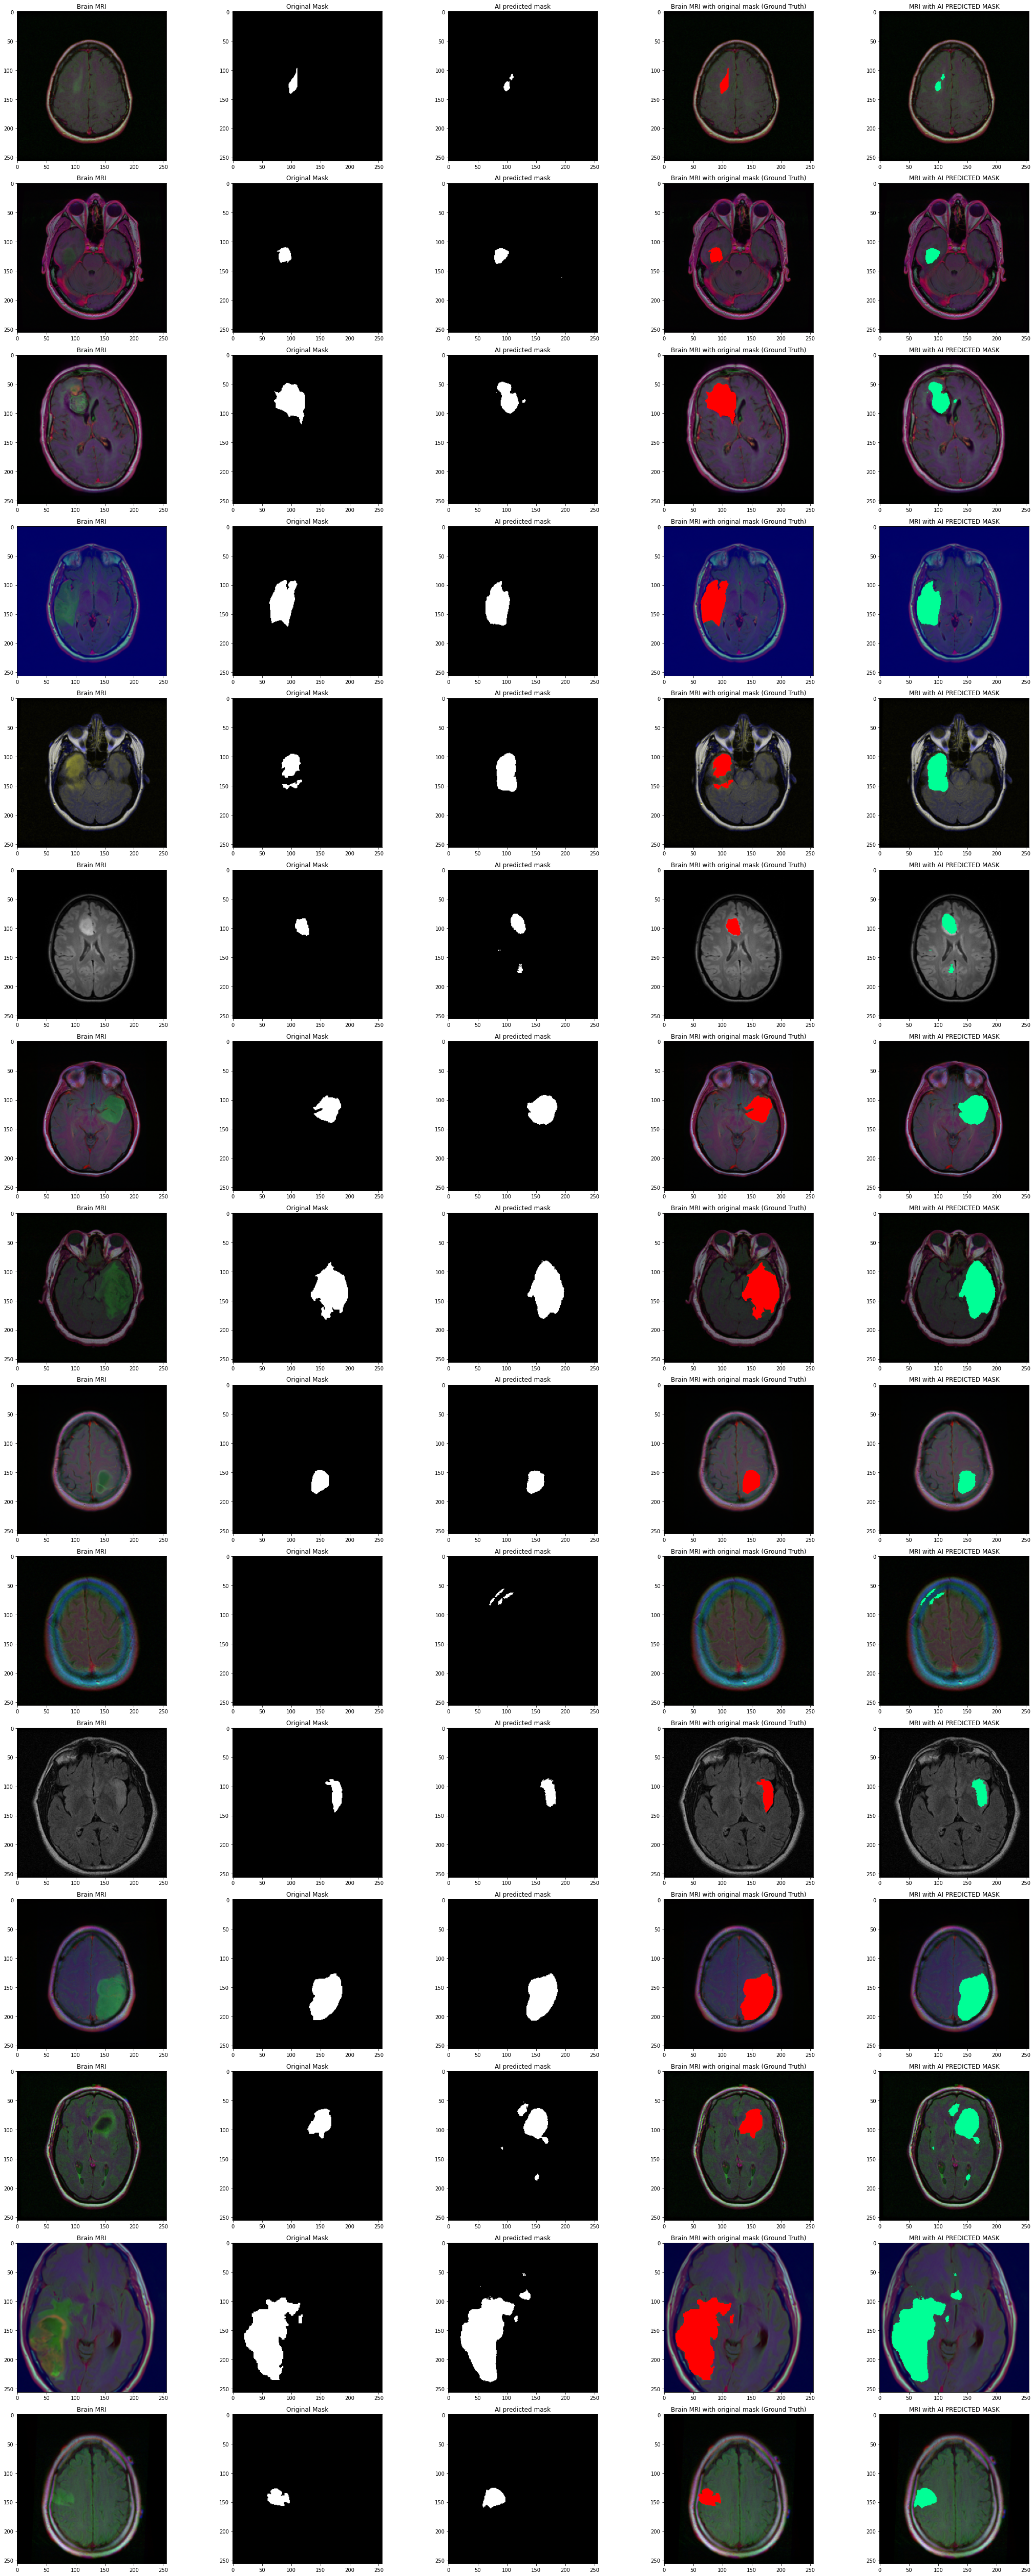

In [105]:
count = 0
fig, axs = plt.subplots(15,5, figsize=(30,70))

for i in range(len(df_pred)):
    if df_pred.has_mask[i]==1 and count<15:
        #read mri images
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     # This is for better visualization
        axs[count][0].imshow(img)
        axs[count][0].title.set_text('Brain MRI')
        
        #read original mask
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].imshow(mask, 'gray')
        axs[count][1].title.set_text('Original Mask')
        
        #read predicted mask
        pred = np.array(df_pred.predicted_mask[i]).squeeze().round()  #The squeeze() function is used to remove single-dimensional entries from the shape of an array.
        axs[count][2].imshow(pred, 'gray')  # gray: to make it black and white look alike
        axs[count][2].title.set_text('AI predicted mask')
        
        #overlay original mask with MRI
        img[mask==255] = (255,0,0)    # Where there is black, we are putting red and then we are combining real and mask image ## 255-white & 0-black
        axs[count][3].imshow(img)
        axs[count][3].title.set_text('Brain MRI with original mask (Ground Truth)')
        
        #overlay predicted mask and MRI
        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[pred==1] = (0,255,150)       # As values in array is standardize, it will range from 0 to 1. So whereever in image there is 1(True), we will make it of green color
        axs[count][4].imshow(img_)
        axs[count][4].title.set_text('MRI with AI PREDICTED MASK')
        
        count +=1
    if (count==15):
        break

fig.tight_layout()

# Thank You
**If you like this and found this helpful, please do *upvote*. *Suggestions are always welcome*, write in comment.**